IMPORT ALL PACKAGES

In [90]:
import torch
import sys
import ast
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch.nn.functional as F
import seaborn as sns

from pathlib import Path
from PIL import Image, ImageEnhance
from collections import Counter, defaultdict
from IPython.display import Markdown

from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.transforms.functional import to_pil_image

from tensorboard.backend.event_processing import event_accumulator

from scipy.ndimage import gaussian_filter

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# add root directory to sys.path
sys.path.append(str(Path().resolve().parent))

from src.models import load_model, SimpleCNN, ComplexCNN, TransferResNet
from src.models import TransferModileNetV2, TransferResNetLarge
from src.dataloader import load_data, TumorDataset
from src.dataloader import LABEL_NAMES, MEAN, STD, IMAGENET_MEAN, IMAGENET_STD

DATA REVIEW AND PREPARATION

<small>Data is stored in ./raw_data under four different labels: Glioma, Meningioma, No Tumor, and Pituitary

In [2]:
# create function to display helper files used
def display_code_file(filepath):
    with open(filepath, 'r') as f:
        code = f.read()
    display(Markdown(f"```python\n{code}\n```"))

# create function to diplay specific functions from helper files
def display_function(filepath, function_name):
    with open(filepath, 'r') as f:
        code = f.read()

    tree = ast.parse(code)

    for node in tree.body:
        if isinstance(node, ast.FunctionDef) and node.name == function_name:
            start_line = node.lineno - 1
            end_line = max(child.lineno for child in ast.walk(node) if hasattr(child, "lineno"))
            lines = code.splitlines()[start_line:end_line]
            function_code = '\n'.join(lines)
            display(Markdown(f"```python\n{function_code}\n```"))
            return
        
    print(f"Function '{function_name}' not found in {filepath}")

# create function to display class methods from helper files
def display_class_method(filepath, class_name, method_name=None):
    with open(filepath, 'r') as f:
        code = f.read()

    tree = ast.parse(code)

    for node in tree.body:
        if isinstance(node, ast.ClassDef) and node.name == class_name:
            if method_name is None:
                # show full class
                start_line = node.lineno - 1
                end_line = max(child.lineno for child in ast.walk(node) if hasattr(child, "lineno"))
                lines = code.splitlines()[start_line:end_line]
                class_code = '\n'.join(lines)
                display(Markdown(f"```python\n{class_code}\n```"))
                return
            
            for child in node.body:
                # show specific method
                if isinstance(child, ast.FunctionDef) and child.name == method_name:
                    start_line = child.lineno - 1
                    end_line = max(grandchild.lineno for grandchild in ast.walk(child) if hasattr(grandchild, "lineno"))
                    lines = code.splitlines()[start_line:end_line]
                    method_code = '\n'.join(lines)
                    display(Markdown(f"```python\n{method_code}\n```"))
                    return
                
            print(f"Method '{method_name}' not found in class '{class_name}'")

    print(f"Class '{class_name}' not found in {filepath}")

In [3]:
# import raw data using "load_data" class written in src/dataloader.py
raw_data_path = r"../raw_data"

dataset = load_data(dataset_path=raw_data_path, 
                    transform_pipeline="raw",
                    return_dataloader=False)

print(f"Total Samples: {len(dataset)}")

Total Samples: 5712


In [4]:
# display code in src/dataloader.py
display_code_file(r"..\src\dataloader.py")

```python
import csv
import torch

from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# image labels
LABEL_NAMES = ["glioma", "meningioma", "notumor", "pituitary"]

# global size, image mean, image std
SIZE = (128, 128)
MEAN = [0.186]
STD = [0.179]
RESNET_SIZE = (224, 224)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

class TumorDataset(Dataset):
    """
    Brain Tumor Dataset for classification
    """
    def __init__(
        self,
        dataset_path: str,
        transform_pipeline: str = "default"
    ):
        self.transform = self.get_transform(transform_pipeline)
        self.data = []

        dataset_path = Path(dataset_path)

        for label in LABEL_NAMES:
            label_dir = dataset_path / label
            if not label_dir.exists():
                continue
            label_id = LABEL_NAMES.index(label) 

            for img_path in label_dir.glob("*.jpg"):
                self.data.append((img_path, label_id))

    def get_transform(self, transform_pipeline: str = "default"):
        xform = None

        if transform_pipeline == "raw":
            xform = transforms.Compose([
                transforms.ToTensor()
            ])

        if transform_pipeline == "default" or transform_pipeline =="validation":
            xform = transforms.Compose([
                transforms.Grayscale(num_output_channels=1),
                transforms.Resize(SIZE),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD)
            ])

        if transform_pipeline == "train":
            xform = transforms.Compose([
                transforms.Grayscale(num_output_channels=1),
                transforms.RandomResizedCrop(size=128, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
                transforms.Resize(SIZE),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(degrees=15),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD)
            ])

        if transform_pipeline == "pretrained_validation":
            xform = transforms.Compose([
                transforms.Grayscale(num_output_channels=3),
                transforms.Resize(RESNET_SIZE),
                transforms.ToTensor(),
                transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
            ])

        if transform_pipeline == "pretrained_train":
            xform = transforms.Compose([
                transforms.Grayscale(num_output_channels=3),
                transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(degrees=20),
                transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.05),
                transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
                transforms.ToTensor(),
                transforms.RandomErasing(p=0.25),
                transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
            ])
        
        if xform is None:
            raise ValueError(f"Invalid transform {transform_pipeline} specified")
        
        return xform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, label_id = self.data[idx]
        img = Image.open(img_path).convert("RGB") # maybe remove .convert("RGB")
        data = (self.transform(img), label_id)

        return data
    

def load_data(
    dataset_path: str,
    transform_pipeline: str = "default",
    return_dataloader: bool = True,
    num_workers: int = 2,
    batch_size: int = 256,
    shuffle: bool = False
) -> DataLoader | Dataset:
    """
    Constructs the dataset or dataloader.

    Args:
        transform_pipeline (str): 'default', 'aug', or other custom transformation pipelines
        return_dataloader (bool): returnes either DataLoader or Dataset
        num_workers (int): data workers
        batch_size (int): batch size
        shuffle (bool): True for Train, False for Validation
    """
    dataset = TumorDataset(dataset_path, transform_pipeline=transform_pipeline)

    if not return_dataloader:
        return dataset
    
    return DataLoader(
        dataset,
        num_workers=num_workers,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=True
    )
```

In [5]:
# find class distribtion
label_counts = Counter(label for _, label in dataset)

In [6]:
# print distribtion
for i, class_name in enumerate(LABEL_NAMES):
    print(f"{class_name}: {label_counts[i]} samples")

glioma: 1321 samples
meningioma: 1339 samples
notumor: 1595 samples
pituitary: 1457 samples


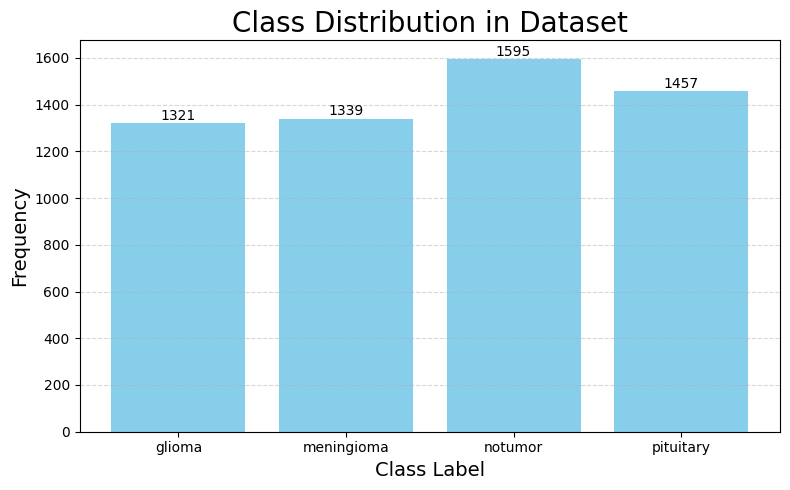

In [7]:
# visualize distribution
counts = [label_counts[i] for i in range(len(LABEL_NAMES))]

plt.figure(figsize=(8, 5))
bars = plt.bar(LABEL_NAMES, counts, color='skyblue')

for bar, count in zip(bars, counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 2, str(count),
             ha='center', va='bottom', fontsize=10)

plt.title("Class Distribution in Dataset", fontsize=20)
plt.xlabel("Class Label", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [8]:
# initialize other statistics
image_sizes = defaultdict(int)
brightness_values = []
channel_means = []
channel_stds = []

# analyze each image
for img, _ in dataset:
    img_np = img.numpy()
    size = img_np.shape[1:]
    image_sizes[size] += 1
    brightness_values.append(img_np.mean())
    channel_means.append(img_np.mean(axis=(1, 2)))
    channel_stds.append(img_np.std(axis=(1, 2)))

# convert to arrays
channel_means = np.stack(channel_means)
channel_stds = np.stack(channel_stds)

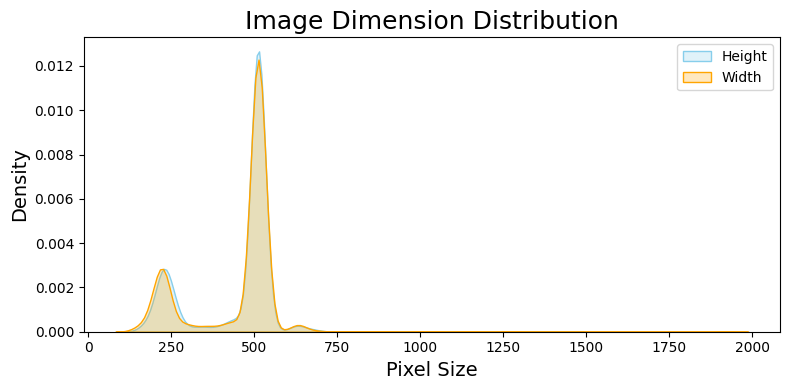

In [9]:
# plot image size distribution
heights = [size[0] for size in image_sizes.keys() for _ in range(image_sizes[size])]
widths = [size[1] for size in image_sizes.keys() for _ in range(image_sizes[size])]

plt.figure(figsize=(8, 4))
sns.kdeplot(heights, label="Height", color="skyblue", fill=True)
sns.kdeplot(widths, label="Width", color="orange", fill=True)
plt.title("Image Dimension Distribution", fontsize=18)
plt.xlabel("Pixel Size", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

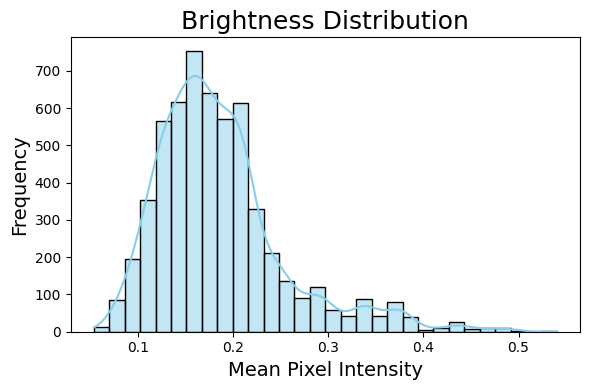

In [10]:
# plot brightness
plt.figure(figsize=(6, 4))
sns.histplot(brightness_values, bins=30, kde=True, color='skyblue')
plt.title("Brightness Distribution", fontsize=18)
plt.xlabel("Mean Pixel Intensity", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.tight_layout()
plt.show()

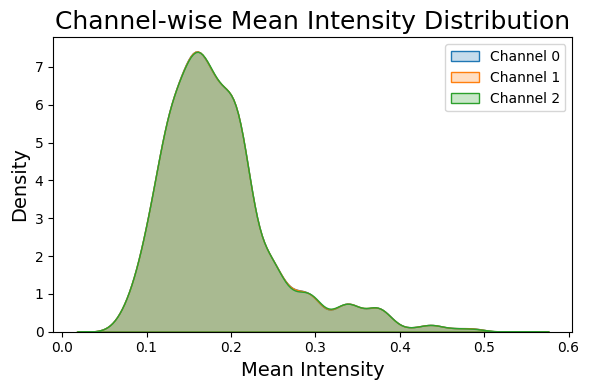

In [11]:
# plot channel-wise mean intensity
plt.figure(figsize=(6, 4))
for i in range(channel_means.shape[1]):
    sns.kdeplot(channel_means[:, i], label=f"Channel {i}", fill=True)
plt.title("Channel-wise Mean Intensity Distribution", fontsize=18)
plt.xlabel("Mean Intensity", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

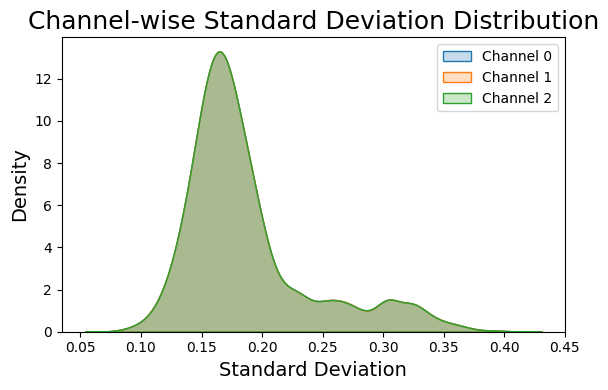

In [27]:
# plot channel-wise std intensity
plt.figure(figsize=(6, 4))
for i in range(channel_stds.shape[1]):
    sns.kdeplot(channel_stds[:, i], label=f"Channel {i}", fill=True)
plt.title("Channel-wise Standard Deviation Distribution", fontsize=18)
plt.xlabel("Standard Deviation", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# create function to display images for each class
def display_sample_images_per_class(dataset, label_names, samples_per_class=5, figsize=(16, 8)):
    """
    Display a grid of sample images per class.

    Args:
        dataset: PyTorch-style dataset returning (image, label)
        label_names: List of class label names (index-aligned)
        samples_per_class: Number of samples to display per class
        figsize: Size of the full figure
    """
    # Collect images per class
    sample_dict = {i: [] for i in range(len(label_names))}
    for img, label in dataset:
        if len(sample_dict[label]) < samples_per_class:
            sample_dict[label].append(img)
        if all(len(v) == samples_per_class for v in sample_dict.values()):
            break

    n_rows = len(label_names)
    n_cols = samples_per_class
    fig, axes = plt.subplots(n_rows, n_cols + 1, figsize=figsize)

    for row_idx, (label_id, images) in enumerate(sample_dict.items()):
        # Left label column
        label_ax = axes[row_idx, 0]
        label_ax.axis("off")
        label_ax.text(0.5, 0.5, label_names[label_id],
                      fontsize=12, ha="center", va="center", weight="bold")

        for col_idx, img_tensor in enumerate(images):
            ax = axes[row_idx, col_idx + 1]
            img_np = img_tensor.numpy()

            if img_np.shape[0] == 1:
                ax.imshow(img_np[0], cmap="gray")
            else:
                ax.imshow(img_np.transpose(1, 2, 0))

            ax.axis("off")

    plt.suptitle(f"{samples_per_class} Sample Images per Class", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()


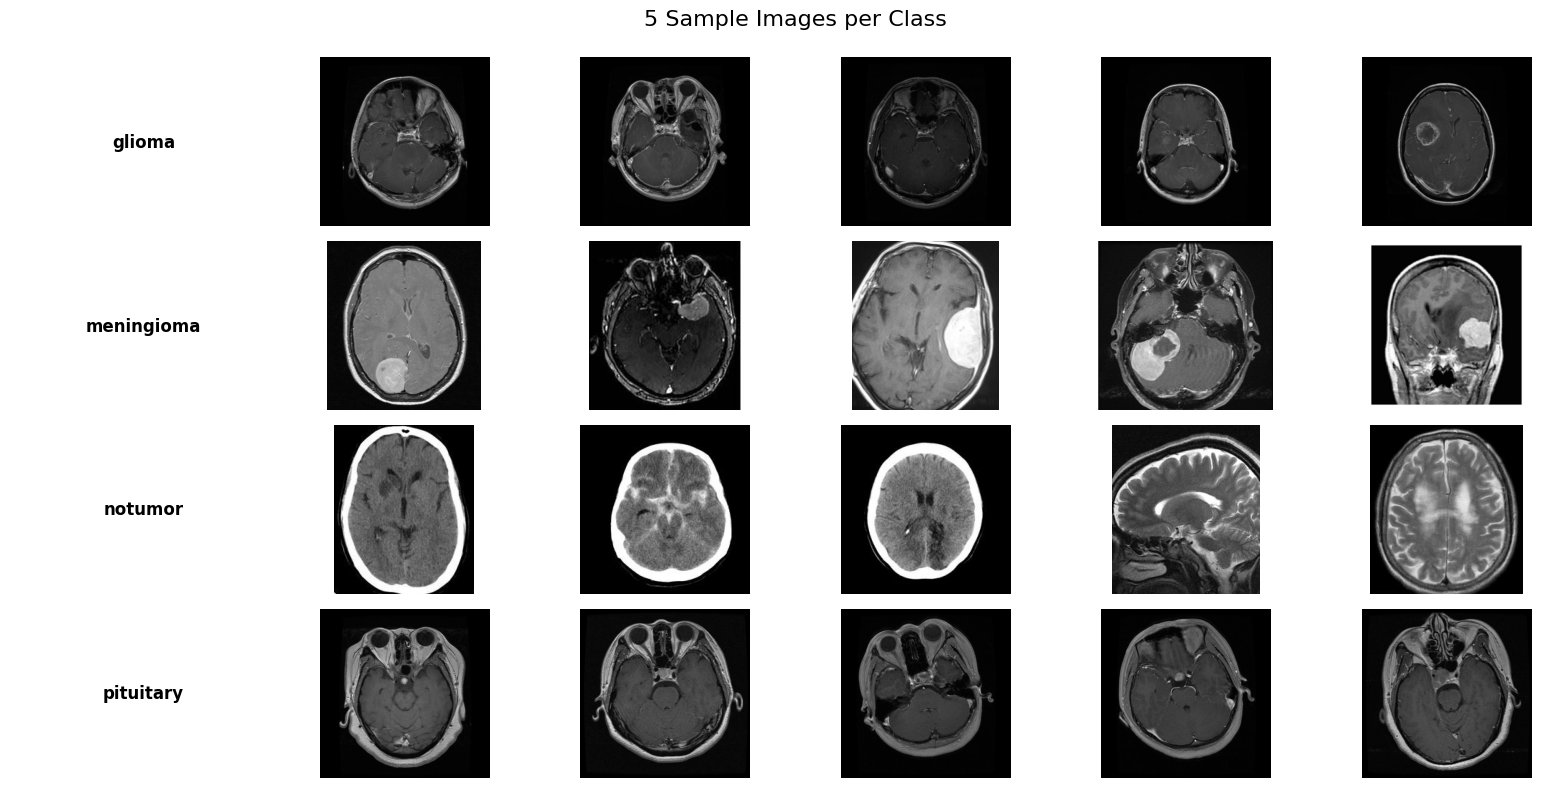

In [22]:
display_sample_images_per_class(dataset, LABEL_NAMES)

In [13]:
# data now needs to be simple into training, validation, testing groups
# this is done using the code in src/utils/split_dataset.py

display_function(r"../src/utils/split_dataset.py", "split_dataset")

```python
def split_dataset(
        source_dir='raw_data',
        dest_dir='data',
        splits=(0.7, 0.15, 0.15),
        seed=42
):
    assert sum(splits) == 1.0, "Splits must sum to 1.0"
    random.seed(seed)
    split_names = ['train', 'val', 'test']
    class_names = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

    # clear and recreate destination directories
    for split in split_names:
        for cls in class_names:
            clear_directory(os.path.join(dest_dir, split, cls))

    # shuffle and copy files
    for cls in class_names:
        class_path = os.path.join(source_dir, cls)
        images = os.listdir(class_path)
        random.shuffle(images)
        total = len(images)
        train_end = int(splits[0] * total)
        val_end = train_end + int(splits[1] * total)

        subsets = {
            'train': images[:train_end],
            'val': images[train_end:val_end],
            'test': images[val_end:]
        }

        for split, files in subsets.items():
            for file in files:
                src = os.path.join(source_dir, cls, file)
                dst = os.path.join(dest_dir, split, cls, file)
                shutil.copy2(src, dst)
```

In [14]:
# import the split data - use transform_pipeline="raw" for purposes of visualization
train_path = r"../data/train"
val_path = r"../data/val"
test_path = r"../data/test"


train_data = load_data(dataset_path=train_path,
                       transform_pipeline="raw", 
                       return_dataloader=False)

val_data = load_data(dataset_path=val_path,
                     transform_pipeline="raw",
                     return_dataloader=False)

test_data = load_data(dataset_path=test_path,
                      transform_pipeline="raw",
                      return_dataloader=False)

print(f"Train Samples: {len(train_data)}\n"
      f"Validation Samples: {len(val_data)}\n"
      f"Test Samples: {len(test_data)}")

Train Samples: 3996
Validation Samples: 855
Test Samples: 861


In [15]:
train_counts = Counter(label for _, label in train_data)
val_counts = Counter(label for _, label in val_data)
test_counts = Counter(label for _, label in test_data)

# print training distribtions
print("Training Distribution")
print('---------------------')
for i, class_name in enumerate(LABEL_NAMES):
    print(f"{class_name}: {train_counts[i]} samples")
print()

# print validation distributions
print("Validation Distribution")
print('-----------------------')
for i, class_name in enumerate(LABEL_NAMES):
    print(f"{class_name}: {val_counts[i]} samples")
print()

# print testing distributions
print("Testing Distribution")
print('--------------------')
for i, class_name in enumerate(LABEL_NAMES):
    print(f"{class_name}: {test_counts[i]} samples")

Training Distribution
---------------------
glioma: 924 samples
meningioma: 937 samples
notumor: 1116 samples
pituitary: 1019 samples

Validation Distribution
-----------------------
glioma: 198 samples
meningioma: 200 samples
notumor: 239 samples
pituitary: 218 samples

Testing Distribution
--------------------
glioma: 199 samples
meningioma: 202 samples
notumor: 240 samples
pituitary: 220 samples


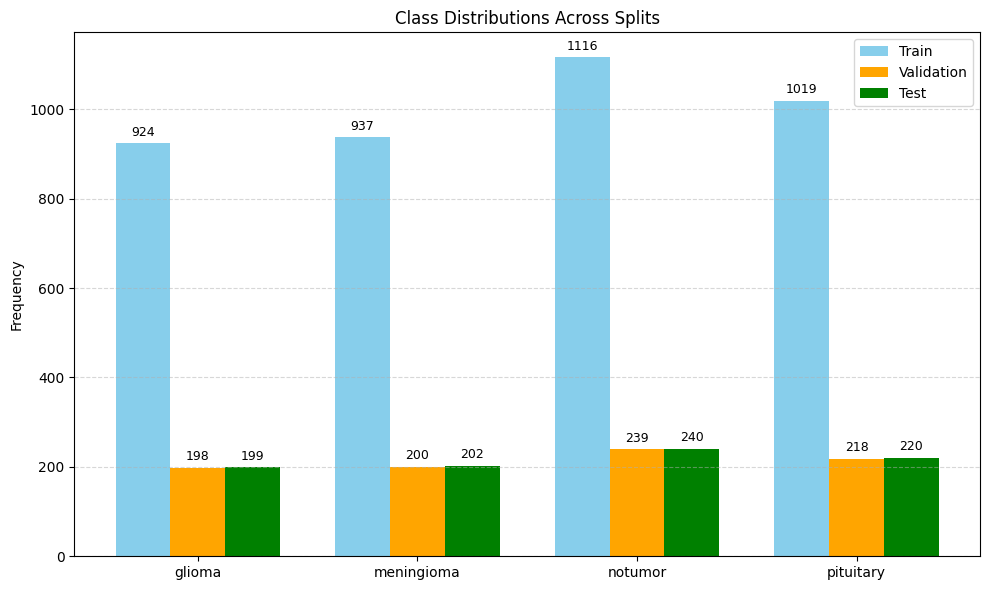

In [16]:
# bar plot distributions for each data set
x = np.arange(len(LABEL_NAMES))
bar_width = 0.25

# convert counters to lists
train_list = [train_counts[i] for i in range(len(train_counts))]
val_list = [val_counts[i] for i in range(len(val_counts))]
test_list = [test_counts[i] for i in range(len(test_counts))]

# plot the data
plt.figure(figsize=(10, 6))
train_bars = plt.bar(x - bar_width, train_list, width=bar_width, label="Train", color="skyblue")
val_bars = plt.bar(x, val_list, width=bar_width, label="Validation", color="orange")
test_bars = plt.bar(x + bar_width, test_list, width=bar_width, label="Test", color="green")

# helper function to plot value counts
def annotate_bars(bars, counts):
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2,
                 height + 10,
                 str(count),
                 ha='center',
                 va='bottom',
                 fontsize=9)

# annotate the plots
annotate_bars(train_bars, train_list)
annotate_bars(val_bars, val_list)
annotate_bars(test_bars, test_list)

# labels and title
plt.xticks(x, LABEL_NAMES)
plt.ylabel("Frequency")
plt.title("Class Distributions Across Splits")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

DATA TRANSFORMS

<small>To prevent overfitting, data is transformed using the code in '../src/dataloader.py'.  Different transforms are done for different models depending on model architecture.  
Custom built models have a singular, grayscale import channel.  Transfer learning models have 3 import channels.

In [17]:
display_class_method(r"../src/dataloader.py", "TumorDataset", "get_transform")

```python
    def get_transform(self, transform_pipeline: str = "default"):
        xform = None

        if transform_pipeline == "raw":
            xform = transforms.Compose([
                transforms.ToTensor()
            ])

        if transform_pipeline == "default" or transform_pipeline =="validation":
            xform = transforms.Compose([
                transforms.Grayscale(num_output_channels=1),
                transforms.Resize(SIZE),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD)
            ])

        if transform_pipeline == "train":
            xform = transforms.Compose([
                transforms.Grayscale(num_output_channels=1),
                transforms.RandomResizedCrop(size=128, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
                transforms.Resize(SIZE),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(degrees=15),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD)
            ])

        if transform_pipeline == "pretrained_validation":
            xform = transforms.Compose([
                transforms.Grayscale(num_output_channels=3),
                transforms.Resize(RESNET_SIZE),
                transforms.ToTensor(),
                transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
            ])

        if transform_pipeline == "pretrained_train":
            xform = transforms.Compose([
                transforms.Grayscale(num_output_channels=3),
                transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(degrees=20),
                transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.05),
                transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
                transforms.ToTensor(),
                transforms.RandomErasing(p=0.25),
                transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
            ])
        
        if xform is None:
            raise ValueError(f"Invalid transform {transform_pipeline} specified")
        
        return xform
```

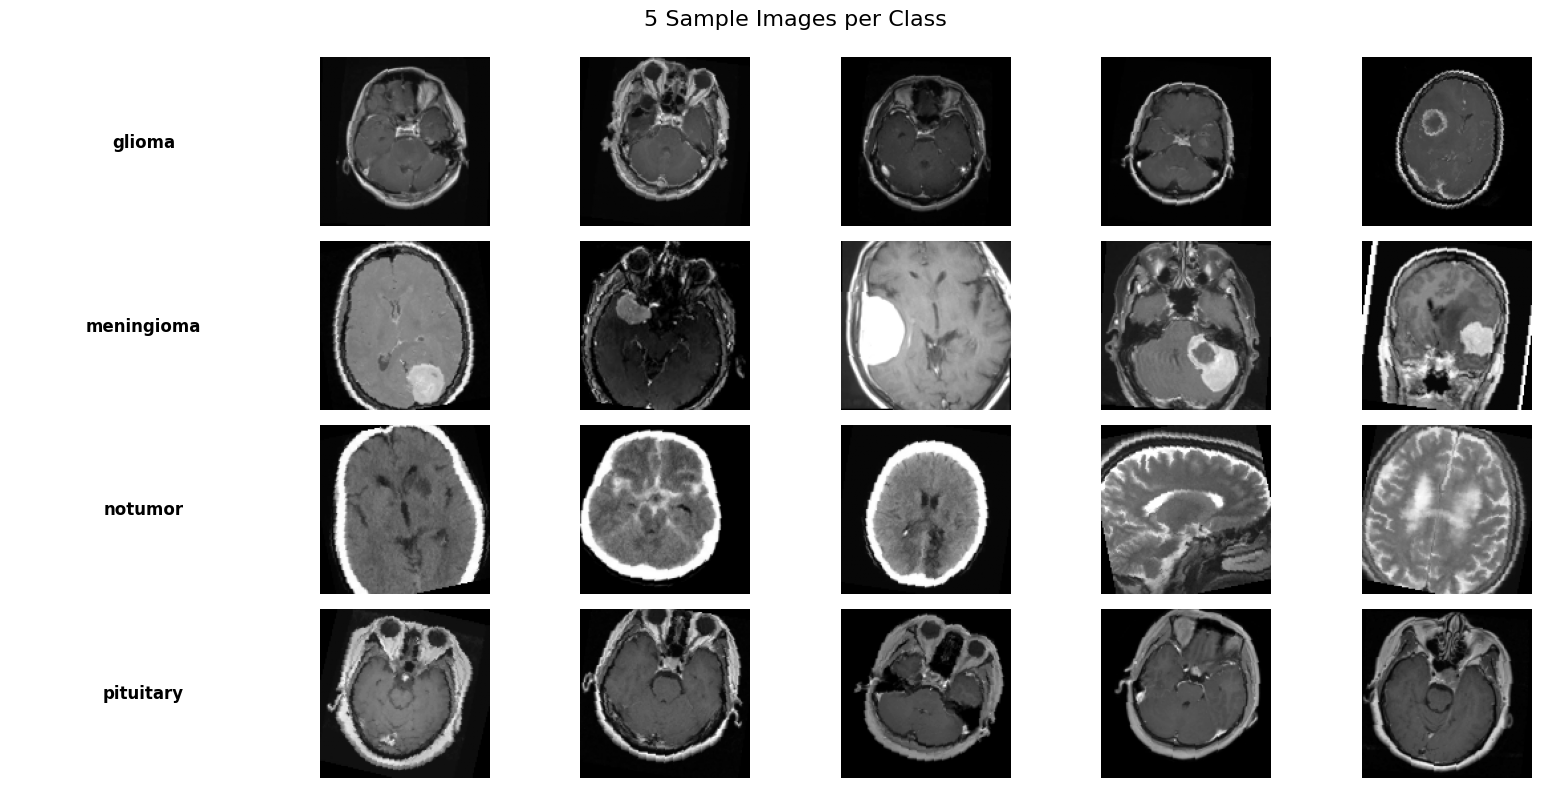

In [23]:
# visualize train dataset for custom models
dataset = load_data(dataset_path=raw_data_path, 
                    transform_pipeline="train",
                    return_dataloader=False)

display_sample_images_per_class(dataset, LABEL_NAMES)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.2108063].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6639653].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.47878015].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..1.1585187].


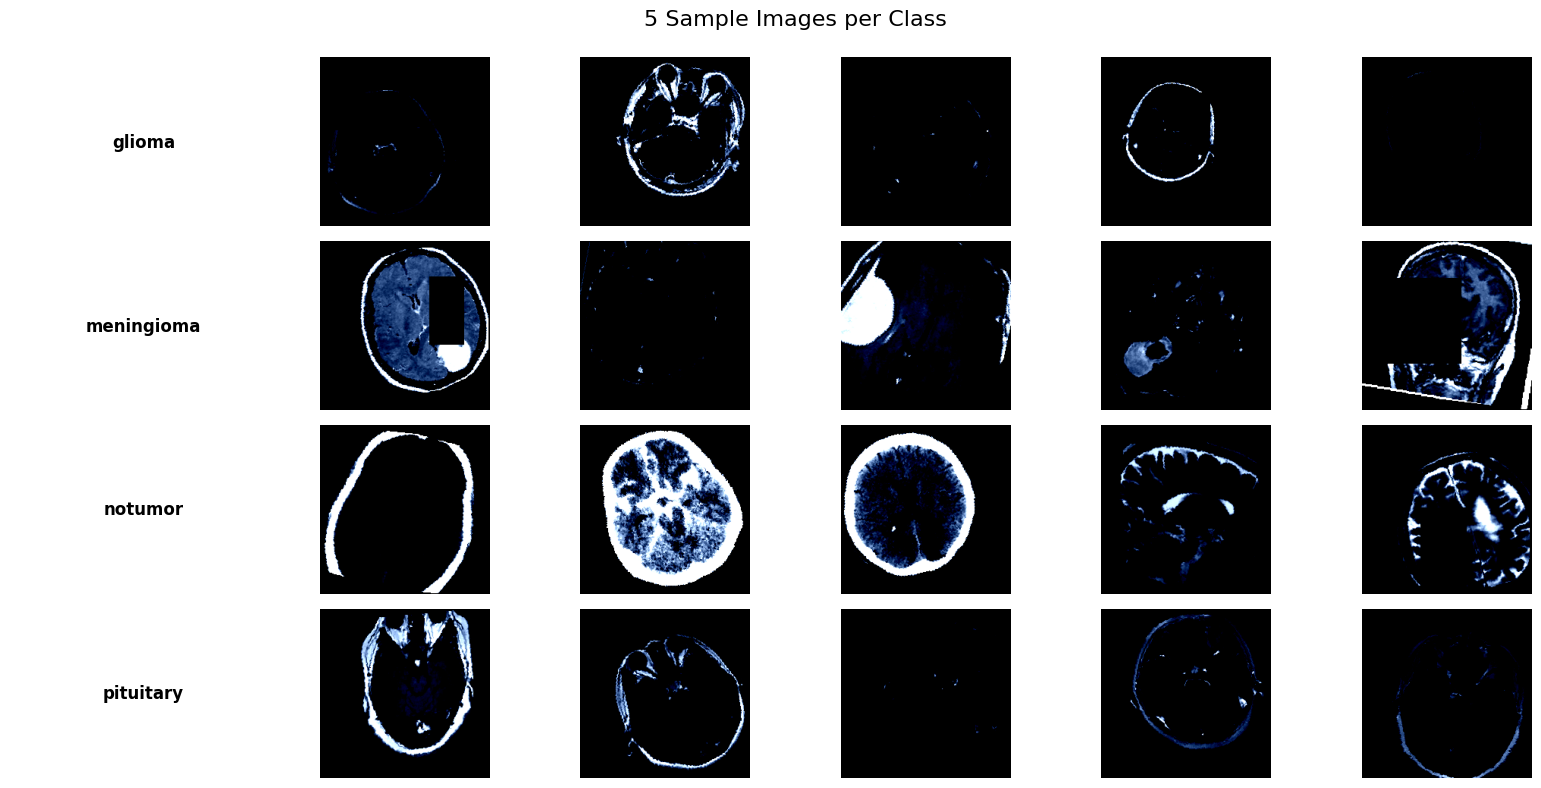

In [ ]:
# visualize train dataset for pretrained models
dataset = load_data(dataset_path=raw_data_path, 
                    transform_pipeline="pretrained_train",
                    return_dataloader=False)

display_sample_images_per_class(dataset, LABEL_NAMES)

TRAIN MODELS

<small>Five separate models were trained
<br/>- SimpleCNN (Three Layer Convolutional Block with a Linear reduction followed by Classifier)
<br/>- ComplexCNN (Initial Stem Layer, Three Larger Convolutional Blocks, and a Final Classifer)
<br/>- TransferResNet (ResNet18 with Last Convolutional Block and Classifier Trained)
<br/>- TransferMobileNet (TransferMobileNetV2 model with Last Two Convolutional Layers and Classifier Trained)
<br/>- TransferResNetLarge (ResNet50 with Last Convolutional Block and Classifier Trained)

<br/>All models were trained with the same hyperparameters and number of epochs
<br/>- Loss Function: Cross Entropy Loss
<br/>- Optimizer: AdamW
<br/>- Learning Rate = 1e-3
<br/>- Weight Decay = 1e-3
<br/>- Batch Size = 256
<br/>- Number of Epochs = 150

<br/>Best performing model was then trained using a Cosine Annealing Learning Rate Scheduler with T_max of 150

In [18]:
# visualization of the Simple CNN Model Creation
display_class_method(r"../src/models.py", "SimpleCNN")

```python
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        # CNN block
        self.conv_block = nn.Sequential(                    # input: 1x128x128
            nn.Conv2d(1, 16, kernel_size=3, padding=1),     # 16x128x128
            nn.ReLU(),
            nn.MaxPool2d(2),                                # 16x64x64

            nn.Conv2d(16, 32, kernel_size=3, padding=1),    # 32x64x64
            nn.ReLU(),
            nn.MaxPool2d(2),                                # 32x32x32

            nn.Conv2d(32, 64, kernel_size=3, padding=1),    # 64x32x32
            nn.ReLU(),
            nn.MaxPool2d(2)                                 # 64x16x16
        )

        # classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    # forward pass
    def forward(self, x):
        x = self.conv_block(x)
        x = self.classifier(x)
        return x
```

In [19]:
# visualization of the Complex CNN Model Creation
display_class_method(r"../src/models.py", "ComplexCNN")

```python
class ComplexCNN(nn.Module):
    class Block(nn.Module):
        def __init__(self,
                     in_channels: int,
                     out_channels: int,
                     stride: int,
                     kernel_size: int = 3):
            super().__init__()

            padding = (kernel_size - 1) // 2

            self.c1 = nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding
            )
            self.n1 = nn.GroupNorm(1, out_channels)
            self.relu1 = nn.ReLU()
            
            self.c2 = nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=1,
                padding=padding
            )
            self.n2 = nn.GroupNorm(1, out_channels)
            self.relu2 = nn.ReLU()

            self.skip = nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=1,
                stride=stride,
                padding=0
            ) if in_channels != out_channels else nn.Identity()

        def forward(self, xi):
            x = self.relu1(self.n1(self.c1(xi)))
            x = self.relu2(self.n2(self.c2(x)))
            return self.skip(xi) + x
        
    def __init__(self,
                 in_channels: int = 1,
                 channels_l0: int = 32,
                 n_blocks: int = 3,
                 num_classes: int = 6):
        super().__init__()

        cnn_layers = [
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=channels_l0,
                kernel_size=11,
                stride=2,
                padding=5
            ),
            nn.ReLU()
        ]

        c1 = channels_l0

        for _ in range(n_blocks):
            c2 = c1 * 2
            cnn_layers.append(self.Block(in_channels=c1, out_channels=c2, stride=2))
            c1 = c2

        cnn_layers.append(nn.Conv2d(c1, num_classes, kernel_size=1))

        self.network = nn.Sequential(*cnn_layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).mean(dim=-1).mean(dim=-1)
    
    def predict(self, x: torch.Tensor) -> torch.Tensor:
        return self(x).argmax(dim=1)
```

In [20]:
# visualization of the ResNet18 Model Creation
display_class_method(r"../src/models.py", "TransferResNet")

```python
class TransferResNet(nn.Module):
    def __init__(self, num_classes: int = 4):
        super().__init__()
        self.base_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

        # replace first conv layer to accept grayscale duplicated to 3 channels
        self.base_model.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )

        # freeze base model layers
        for name, param in self.base_model.named_parameters():
            if "layer4" in name or "fc" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        # replace classifier head
        self.base_model.fc = nn.Linear(
            in_features=self.base_model.fc.in_features,
            out_features=num_classes
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.base_model(x)
```

In [21]:
# visualization of the MobileNetV2 Model Creation
display_class_method(r"../src/models.py", "TransferModileNetV2")

```python
class TransferModileNetV2(nn.Module):
    def __init__(self, num_classes: int = 4):
        super().__init__()
        self.base_model = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)

        # freeze all layers
        for name, param in self.base_model.features.named_parameters():
            if not (name.startswith("17") or name.startswith("18")):
                param.requires_grad = False
            else:
                param.requires_grad = True

        # replace classifier head
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(
                in_features=self.base_model.last_channel,
                out_features=num_classes
            ))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.base_model(x)
```

In [22]:
# visualization of the ResNet50 Model Creation
display_class_method(r"../src/models.py", "TransferResNetLarge")

```python
class TransferResNetLarge(nn.Module):
    def __init__(self, num_classes: int = 4):
        super().__init__()
        self.base_model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

        # freeze all but last layers
        for name, param in self.base_model.named_parameters():
            if "layer4" in name or "fc" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        # replace classifier head
        self.base_model.fc = nn.Linear(
            in_features=self.base_model.fc.in_features,
            out_features=num_classes
        )

    def forward(self, x):
        return self.base_model(x)
```

In [23]:
# visualization of the training loop
display_function(r"../src/train.py", "train")

```python
def train(
    exp_dir: str = "logs",
    model_name: str = "simpleCNN",
    num_epoch: int = 50,
    lr: float = 1e-3,
    weight_decay: float = 1e-3,
    batch_size: int = 256,
    scheduler: bool = False,
    seed: int = 2024,
    **kwargs
):
    # use GPU or MPS if available, otherwise use CPU
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
    else:
        print("CUDA not available, using CPU")
        device = torch.device("cpu")

    # set random seeds
    torch.manual_seed(seed)
    np.random.seed(seed)

    # create directory and tensorboard
    log_dir = Path(exp_dir) / f"{model_name}_{datetime.now().strftime('%m%d_%H%M%S')}"
    logger = tb.SummaryWriter(log_dir)

    # call and log model
    model = load_model(model_name, **kwargs)
    model = model.to(device)
    model.train()

    # select train and validation pipelines
    if model_name == "transferResNet" or model_name == "transferMobileNet" or model_name == "transferResNetLarge":
        train_transform = "pretrained_train"
        val_transform = "pretrained_validation"
        mean_val = IMAGENET_MEAN
        std_val = IMAGENET_STD
    else:
        train_transform = "train"
        val_transform = "validation"
        mean_val = MEAN
        std_val = STD

    # load data
    train_data = load_data("data/train",
                           transform_pipeline=train_transform,
                           shuffle=True,
                           batch_size=batch_size,
                           num_workers=4)
    val_data = load_data("data/val",
                         transform_pipeline=val_transform,
                         shuffle=False)
    
    train_images = denormalize(next(iter(train_data))[0], mean=mean_val, std=std_val)
    val_images = denormalize(next(iter(val_data))[0], mean=mean_val, std=std_val)
    
    logger.add_images("train_images", train_images)
    logger.add_images("val_images", val_images)

    # create loss function and optimizer
    loss_func = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(),
                                  lr=lr,
                                  weight_decay=weight_decay)
    
    # use learning rate scheduler if true
    if scheduler:
        scheduler = CosineAnnealingLR(optimizer, T_max=num_epoch)


    # initialize global step
    global_step = 0
    
    # training loop
    for epoch in range(num_epoch):
        # initialize metrics
        train_acc_metric = AccuracyMetric()
        val_acc_metric = AccuracyMetric()

        # set model to training
        model.train()

        for img, label in train_data:
            # send data to device
            img, label = img.to(device), label.to(device)

            # forward pass
            logits = model(img)
            loss = loss_func(logits, label)

            logger.add_scalar("train/loss", loss.item(), global_step=global_step)

            # back propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute accuracy
            preds = torch.argmax(logits, dim=1)
            train_acc_metric.add(preds, label)

            global_step += 1

        # validation loop
        model.eval()
        with torch.inference_mode():

            val_losses = []

            for img, label in val_data:
                # send val data to device
                img, label = img.to(device), label.to(device)

                # predict on model
                logits = model(img)
                loss = loss_func(logits, label)

                val_losses.append(loss.item())

                # compute accuracy
                preds = torch.argmax(logits, dim=1)
                val_acc_metric.add(preds, label)

            # calculate average validation loss
            avg_val_loss = sum(val_losses) / len(val_losses)
            logger.add_scalar("val/loss", avg_val_loss, global_step=global_step)

        # calculate accuracies at epoch level
        epoch_train_acc = train_acc_metric.compute()["accuracy"]
        epoch_val_acc = val_acc_metric.compute()["accuracy"]

        # log accuracies
        logger.add_scalar("train/accuracy", epoch_train_acc, global_step=global_step)
        logger.add_scalar("val/accuracy", epoch_val_acc, global_step=global_step)

        # log scheduler if true
        if scheduler:
            logger.add_scalar("lr", scheduler.get_last_lr()[0], global_step=global_step)
            scheduler.step()

        # print first, last, or every 5th epoch
        if epoch == 0 or epoch == num_epoch - 1 or (epoch + 1) % 5 == 0:
            print(
                f"Epoch {epoch + 1:2d} / {num_epoch:2d}: "
                f"Training Accuracy={epoch_train_acc:.4f} "
                f"val_acc={epoch_val_acc:.4f}"
            )
            torch.save(model.state_dict(), log_dir / f"{model_name}_epoch{epoch}.th")

    # save model
    save_model(model)

    # save a copy of model weights in log
    torch.save(model.state_dict(), log_dir / f"{model_name}.th")
    print(f"Model saved to {log_dir / f'{model_name}.th'}")
```

In [ ]:
# create helper function to plot training curves from Tensorboard logs
def plot_training_curves(fig_runs,
                         tag="train/loss",
                         smooth=0.0,
                         epoch_tag_candidates=("val/loss", "val/accuracy", "train/accuracy"),
                         title=None,
                         ylabel=None,
                         figsize=(8, 5),
                         logy=False,
                         ylim=None):
    def latest_event_file(p):
        if os.path.isdir(p):
            files = glob.glob(os.path.join(p, "**", "events.out.tfevents.*"), recursive=True)
            if not files: raise FileNotFoundError(f"No events files under: {p}")
            return max(files, key=os.path.getmtime)
        if os.path.isfile(p): return p
        raise FileNotFoundError(f"Path not found: {p}")
    
    def infer_steps_per_epoch(ea):
        tags = set(ea.Tags().get("scalars", []))
        epoch_tag = next((t for t in epoch_tag_candidates if t in tags), None)
        if epoch_tag is None:
            raise ValueError(f"No epoch-level tag found among {epoch_tag_candidates}."
                             f"Available: {sorted(tags)}")
        steps = [x.step for x in ea.Scalars(epoch_tag)]
        if len(steps) < 2:
            raise ValueError(f"Not enough points in '{epoch_tag} to infer steps per epoch.")
        return int(np.median(np.diff(steps)))
    
    def ema(vals, a):
        if not (0 < a < 1): return vals
        out, e = [], None
        for v in vals:
            e = v if e is None else a*e + (1-a)*v
            out.append(e)
        return out
    
    plt.figure(figsize=figsize)
    
    for run in fig_runs:
        label, path = run["label"], run["path"]
        ea = event_accumulator.EventAccumulator(latest_event_file(path))
        ea.Reload()

        if tag not in ea.Tags().get("scalars", []):
            print(f"[skip] '{tag}' not in {label}. Available: {ea.Tags().get('scalars', [])}")
            continue

        steps_per_epoch = infer_steps_per_epoch(ea)
        scalars = ea.Scalars(tag)
        steps = [s.step for s in scalars]
        values = [s.value for s in scalars]
        epochs = [s // steps_per_epoch for s in steps]
        values = ema(values, smooth) if smooth else values

        plt.plot(epochs, values, label=label)

    plt.xlabel("Epoch")
    plt.ylabel(ylabel or tag.split("/")[-1])
    plt.title(title or f"{tag} vs Epoch")
    plt.grid(True, alpha=0.5)
    if logy:
        plt.yscale("log")
    if ylim:
        plt.ylim(ylim)
    plt.legend()
    plt.tight_layout()
    plt.show()

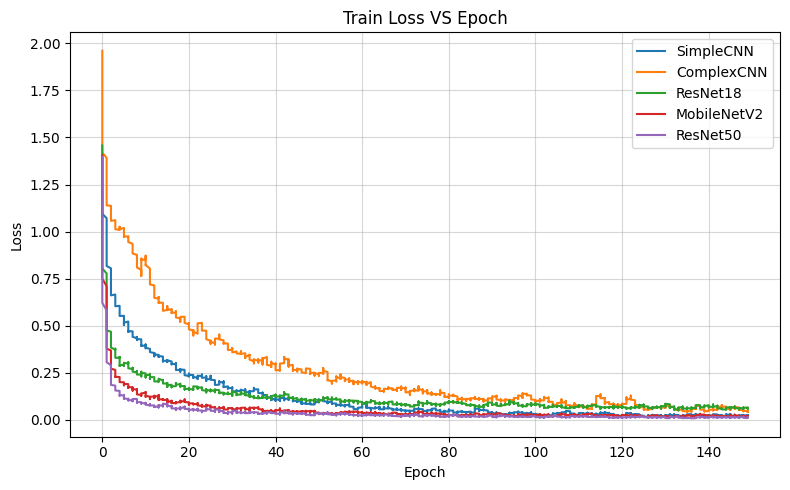

In [62]:
runs = [
    {"label": "SimpleCNN", "path": r"../logs/simpleCNN_0803_205429"},
    {"label": "ComplexCNN", "path": r"../logs/complexCNN_0803_185751"},
    {"label": "ResNet18", "path": r"../logs/transferResNet_0805_212725"},
    {"label": "MobileNetV2", "path": r"../logs/transferMobileNet_0805_145121"},
    {"label": "ResNet50", "path": r"../logs/transferResNetLarge_0806_085629"}
]

plot_training_curves(runs, tag="train/loss", smooth=0.9, title="Train Loss VS Epoch", ylabel="Loss")

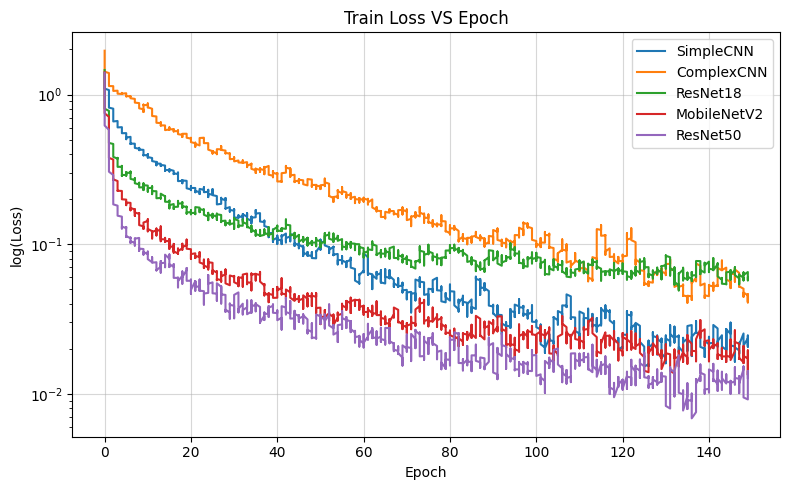

In [63]:
plot_training_curves(runs, tag="train/loss", smooth=0.9, title="Train Loss VS Epoch", ylabel="log(Loss)", logy=True)

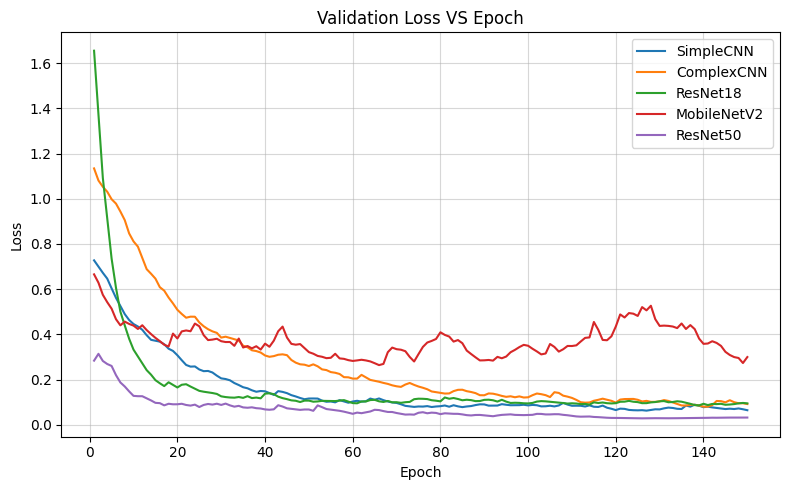

In [78]:
plot_training_curves(runs, tag="val/loss", smooth=0.75, title="Validation Loss VS Epoch", ylabel="Loss")

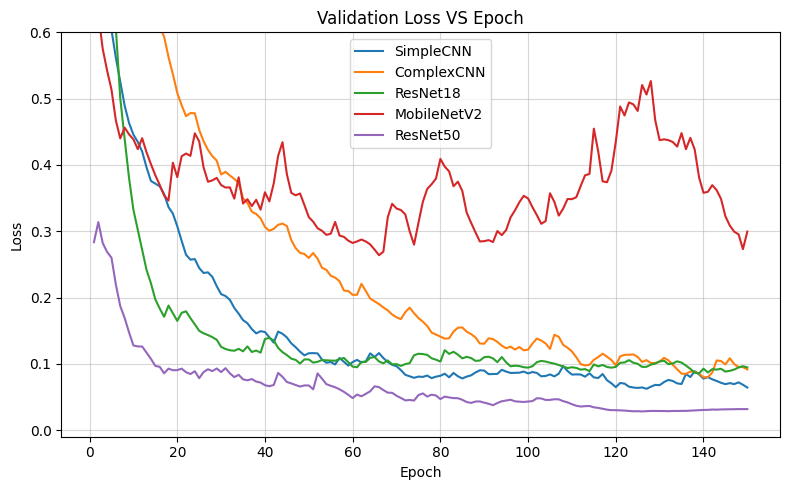

In [77]:
plot_training_curves(runs, tag="val/loss", smooth=0.75, title="Validation Loss VS Epoch", ylabel="Loss", ylim=(-0.01, 0.6))

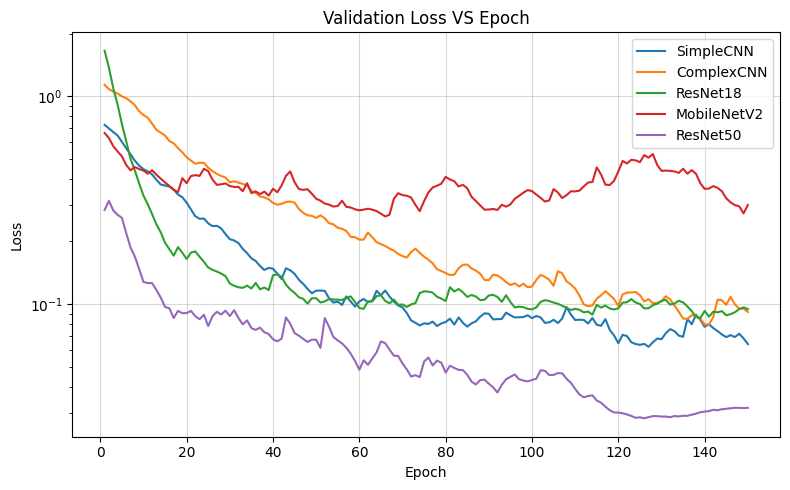

In [71]:
plot_training_curves(runs, tag="val/loss", smooth=0.75, title="Validation Loss VS Epoch", ylabel="Loss", logy=True)

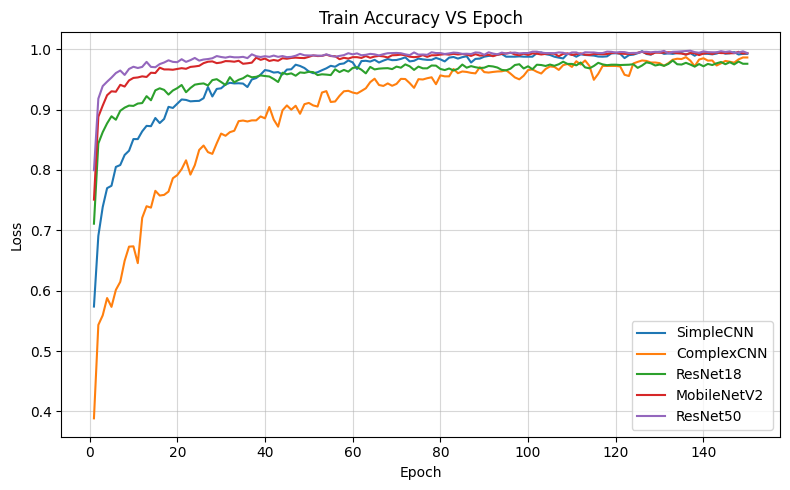

In [67]:
plot_training_curves(runs, tag="train/accuracy", title="Train Accuracy VS Epoch", ylabel="Loss")

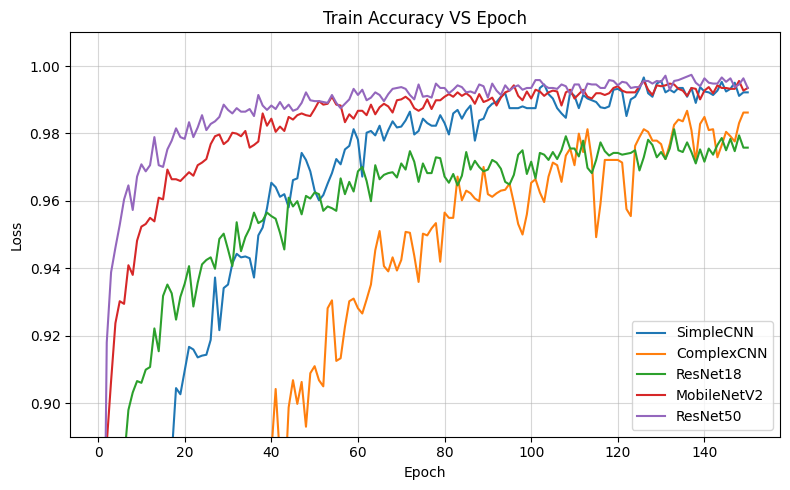

In [86]:
plot_training_curves(runs, tag="train/accuracy", title="Train Accuracy VS Epoch", ylabel="Loss", ylim=(0.89, 1.01))

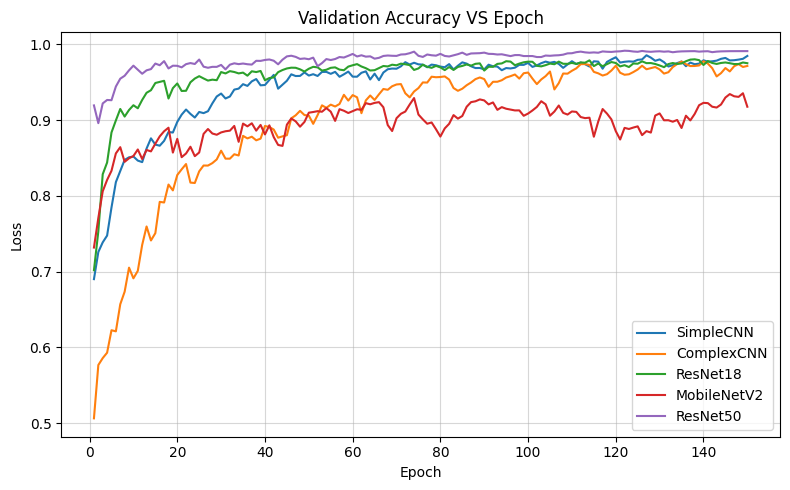

In [75]:
plot_training_curves(runs, tag="val/accuracy", smooth=0.5, title="Validation Accuracy VS Epoch", ylabel="Loss")

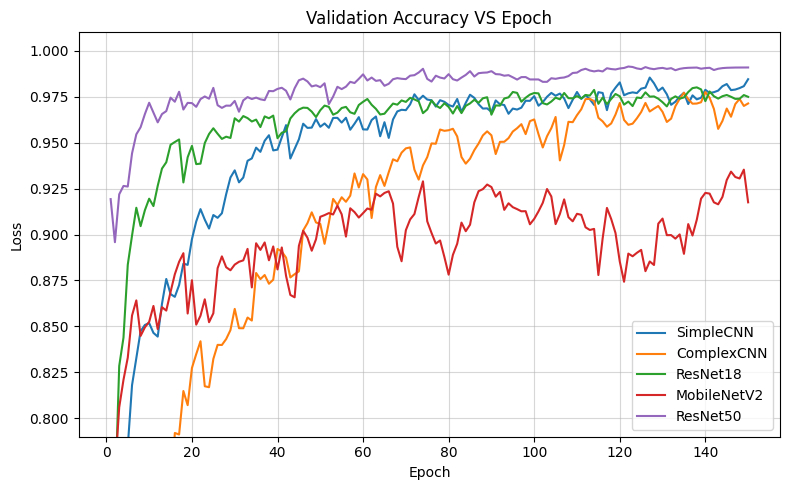

In [87]:
plot_training_curves(runs, tag="val/accuracy", smooth=0.5, title="Validation Accuracy VS Epoch", ylabel="Loss", ylim=(0.79, 1.01))

In [101]:
# create a helper function to plot confusion matricies
def plot_confusion_matrix(model,
                          data_loader,
                          device,
                          label_names,
                          title_prefix="Model"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for img, label in data_loader:
            img, label = img.to(device), label.to(device)
            logits = model(img)
            pred = torch.argmax(logits, dim=1)

            all_preds.append(pred.cpu())
            all_labels.append(label.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    cm = confusion_matrix(all_labels, all_preds)
    acc = accuracy_score(all_labels, all_preds)

    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=label_names)
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    plt.title(f"{title_prefix} - Test Accuracy: {acc*100:.1f}%")
    plt.show()

In [ ]:
# load testing data for use in Full Model evaluation
test_data_full = load_data(
    r"../data/test",
    transform_pipeline="validation",
    shuffle=False,
    batch_size=64
)

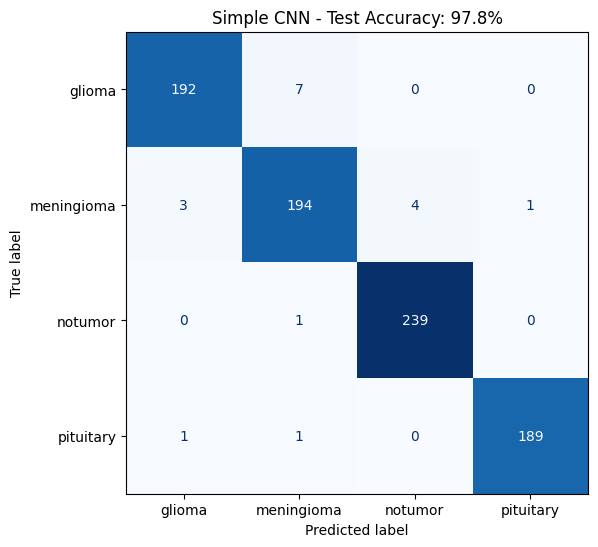

In [ ]:
# Simple CNN Confusion Matrix
simpleCNN_path = r"../src/final_models/simpleCNN.th"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

simpleCNN = load_model("simpleCNN")
simpleCNN.load_state_dict(torch.load(simpleCNN_path, map_location=device))
simpleCNN.to(device)

plot_confusion_matrix(simpleCNN, test_data_full, device, LABEL_NAMES, "Simple CNN")

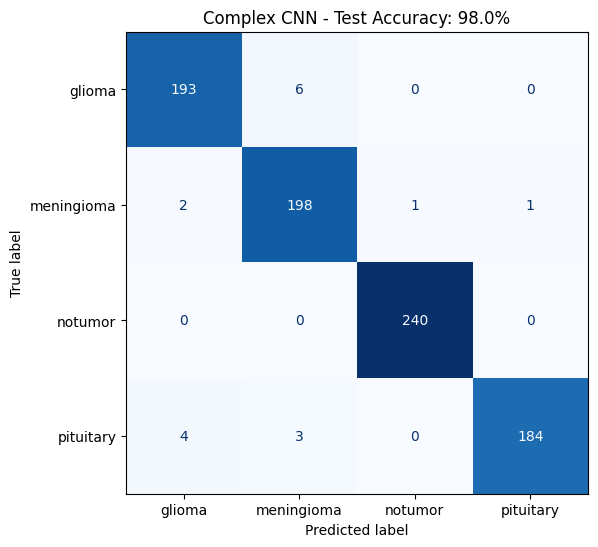

In [ ]:
# Complex CNN Confusion Matrix
complexCNN_path = r"../src/final_models/complexCNN.th"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

complexCNN = load_model("complexCNN")
complexCNN.load_state_dict(torch.load(complexCNN_path, map_location=device))
complexCNN.to(device)

plot_confusion_matrix(complexCNN, test_data_full, device, LABEL_NAMES, "Complex CNN")

In [105]:
# load testing data for use in Pretrained Model evaluation
test_data_pre = load_data(
    r"../data/test",
    transform_pipeline="pretrained_validation",
    shuffle=False,
    batch_size=64
)

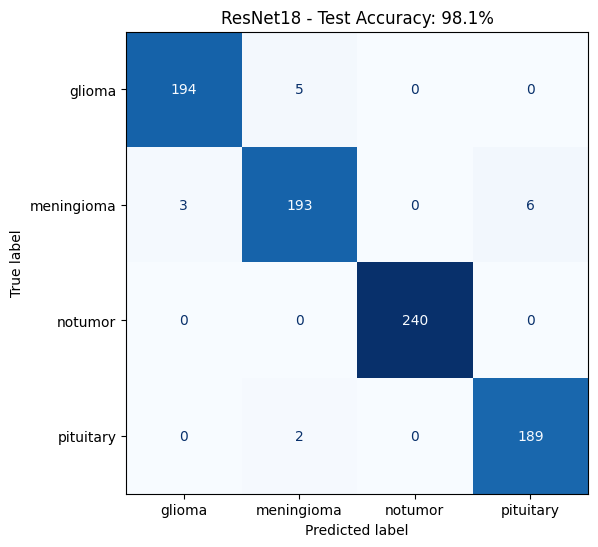

In [106]:
# ResNet18 Confusion Matrix
resNet18_path = r"../src/final_models/transferResNet.th"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resNet18 = load_model("transferResNet")
resNet18.load_state_dict(torch.load(resNet18_path, map_location=device))
resNet18.to(device)

plot_confusion_matrix(resNet18, test_data_pre, device, LABEL_NAMES, "ResNet18")

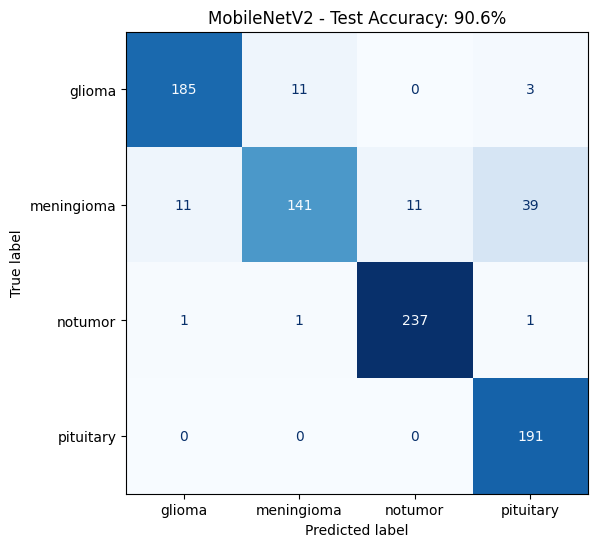

In [ ]:
# MobileNetV2 Confusion Matrix
mobileNetV2_path = r"../src/final_models/transferMobileNet.th"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mobileNetV2 = load_model("transferMobileNet")
mobileNetV2.load_state_dict(torch.load(mobileNetV2_path, map_location=device))
mobileNetV2.to(device)

plot_confusion_matrix(mobileNetV2, test_data_pre, device, LABEL_NAMES, "MobileNetV2")

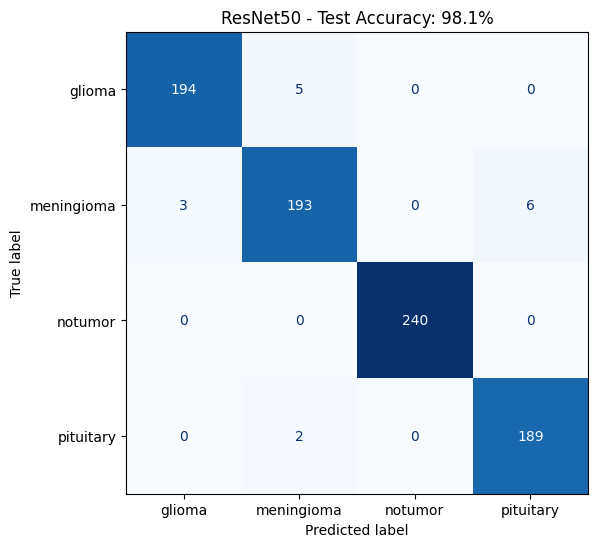

In [108]:
# ResNet50 Confusion Matrix
resNet50_path = r"../src/final_models/transferResNet.th"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resNet50 = load_model("transferResNet")
resNet50.load_state_dict(torch.load(resNet50_path, map_location=device))
resNet50.to(device)

plot_confusion_matrix(resNet50, test_data_pre, device, LABEL_NAMES, "ResNet50")